In [1]:
%cd ../../

%load_ext autoreload
%autoreload 2

/home/hoanghu/projects/Food-Waste-Optimization


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from scipy import stats

In [3]:
plt.style.use('seaborn-v0_8-darkgrid')
pio.templates.default = "seaborn"

# Load data

In [4]:
path = "src/data/basic_mvp_data/Sold lunches.csv"

raw_lunch = pd.read_csv(path, delimiter=';', encoding='utf-8-sig', parse_dates=['Date'], low_memory=False)
raw_lunch.head()

,Date,Receipt time,Restaurant,Food Category,Dish,pcs,Hiilijalanjälki
0,2.1.2023,10:31,600 Chemicum,Liha,"Uunimakkaraa,sinappikastiketta",1,"0,9"
1,2.1.2023,10:32,600 Chemicum,Kala,Kalapuikot tillikermaviilikast,1,"1,04"
2,2.1.2023,10:32,600 Chemicum,Liha,"Uunimakkaraa,sinappikastiketta",1,"0,9"
3,2.1.2023,10:35,600 Chemicum,Kala,Kalapuikot tillikermaviilikast,1,"1,04"
4,2.1.2023,10:36,600 Chemicum,Liha,"Uunimakkaraa,sinappikastiketta",2,"1,8"


# Process data

## Extract menu per day for each restaurant

In [5]:
lunches = (
    raw_lunch
    .replace(
        {
            '600 Chemicum': 'Chemicum',
            '610 Physicum': 'Physicum',
            '620 Exactum': 'Exactum',
            'Kala': 'fish',
            'Liha': 'meat',
            'Vegaani': 'vegan',
            'Kasvis': 'vegetarian',
            'Kana': 'chicken'
        },
    )
    .rename(columns={
        'Date': 'date',
        'Restaurant': 'restaurant',
        'Food Category': 'category',
        'Dish': 'dish'
    })
    
)

lunches['pcs'] = pd.to_numeric(lunches.pcs, errors='coerce')
lunches['date'] = pd.to_datetime(lunches.date, format='%d.%m.%Y', errors='coerce')

lunches = (
    lunches
    .groupby(['date', 'restaurant', 'category', 'dish'])['pcs']
    .sum()
    .reset_index()
)

# Remove 'Not Napped'
lunches = lunches[lunches['category'] != 'Not Mapped']

# Remove 'takeaway'
def is_takeaway(s: str):
    return s.lower().count('take away') > 0

lunches['is_takeaway'] = lunches['dish'].map(is_takeaway)
lunches = lunches[~lunches['is_takeaway']].drop(columns='is_takeaway')

lunches.head(10)

,date,restaurant,category,dish,pcs
2,2023-01-02,Chemicum,fish,Kalapuikot tillikermaviilikast,78.0
4,2023-01-02,Chemicum,meat,"Uunimakkaraa,sinappikastiketta",165.0
5,2023-01-02,Chemicum,vegan,Marokkolainen linssipata,84.0
8,2023-01-03,Chemicum,fish,"Herkkulohipihvit, punajuurimaj",105.0
10,2023-01-03,Chemicum,fish,Kalapuikot tillikermaviilikast,52.0
12,2023-01-03,Chemicum,meat,Pasta Carbonara,17.0
13,2023-01-03,Chemicum,meat,"Uunimakkaraa,sinappikastiketta",56.0
14,2023-01-03,Chemicum,vegan,Marokkolainen linssipata,62.0
16,2023-01-03,Chemicum,vegan,Vegaaninen buttertofu,51.0
17,2023-01-03,Chemicum,vegetarian,Feta-pinaattilasagnette,29.0


In [6]:
dish_count = (
    lunches
    .groupby(['date' ,'restaurant'])['category']
    .value_counts()
    .reset_index()
    .pivot(index=['date', 'restaurant'], columns='category', values='count')
    .fillna(0.0)
    .rename(columns={
        'chicken': 'num_cat_chicken',
        'fish': 'num_cat_fish',
        'meat': 'num_cat_meat',
        'vegan': 'num_cat_vegan',
        'vegetarian': 'num_cat_vegetarian',
    })
    .reset_index()
)
dish_count.head()

category,date,restaurant,num_cat_chicken,num_cat_fish,num_cat_meat,num_cat_vegan,num_cat_vegetarian
0,2023-01-02,Chemicum,0.0,1.0,1.0,1.0,0.0
1,2023-01-03,Chemicum,0.0,2.0,2.0,2.0,1.0
2,2023-01-04,Chemicum,0.0,2.0,1.0,1.0,0.0
3,2023-01-05,Chemicum,1.0,2.0,0.0,1.0,0.0
4,2023-01-09,Chemicum,0.0,2.0,1.0,2.0,0.0


In [7]:
num_pcs = lunches.groupby(['date', 'restaurant'])['pcs'].sum().reset_index()
num_pcs.head()

,date,restaurant,pcs
0,2023-01-02,Chemicum,327.0
1,2023-01-03,Chemicum,372.0
2,2023-01-04,Chemicum,387.0
3,2023-01-05,Chemicum,471.0
4,2023-01-09,Chemicum,568.0


In [8]:
dishes = (
    dish_count
    .merge(
        num_pcs,
        on=['date', 'restaurant'],
        how='inner'
    )
    .drop(columns=['date'])
)

dishes.head()

,restaurant,num_cat_chicken,num_cat_fish,num_cat_meat,num_cat_vegan,num_cat_vegetarian,pcs
0,Chemicum,0.0,1.0,1.0,1.0,0.0,327.0
1,Chemicum,0.0,2.0,2.0,2.0,1.0,372.0
2,Chemicum,0.0,2.0,1.0,1.0,0.0,387.0
3,Chemicum,1.0,2.0,0.0,1.0,0.0,471.0
4,Chemicum,0.0,2.0,1.0,2.0,0.0,568.0


# Start exploring

## Use distribution visualization

In [9]:
RESTAURANT = ['Chemicum', 'Exactum']

In [10]:
# Plot
fig = make_subplots(
    rows=1, cols=2,
    specs=[
        [{'type': 'scatter'}, {'type': 'scatter'}]
    ],
    subplot_titles=RESTAURANT
)

for i, restaurant in enumerate(RESTAURANT):
    showlegend = i == 0

    dishes_restaurant = dishes[dishes['restaurant'] == restaurant]

    dishes_restaurant['alot_vegan'] = dishes_restaurant['num_cat_vegan'] >= 2

    pcs_alot_vegan = dishes_restaurant[dishes_restaurant['alot_vegan']]['pcs']
    pcs_not_alot_vegan = dishes_restaurant[~dishes_restaurant['alot_vegan']]['pcs']


    fx1 = ff.create_distplot([pcs_alot_vegan], ['distplot'], curve_type='kde')
    fig.add_trace(
        go.Scatter(x=fx1.data[1]['x'], y=fx1.data[1]['y'], name='More vegan', marker=dict(color='#4c72b0'), legendgroup="blue", fill='tozeroy', showlegend=showlegend),
        row=1, col=i+1
    )

    fx1 = ff.create_distplot([pcs_not_alot_vegan], ['distplot'], curve_type='kde')
    fig.add_trace(
        go.Scatter(x=fx1.data[1]['x'], y=fx1.data[1]['y'], name='Less vegan', marker=dict(color='#dd8452'), legendgroup="orange", fill='tozeroy', showlegend=showlegend),
        row=1, col=i+1
    )

fig.update_layout(
    height=600, 
    width=1200,
    title_text="<b>Distribution of no. pieces when the menu has at least 2 vegan versus less</b>",
    title_font_size=20,
    xaxis_tickangle=-90,
    title_x=0.5,
)
fig.update_yaxes(visible=False)

fig.show()

## Use t-test

### Test the normality with QQ-plot

/tmp/ipykernel_59750/1940532933.py:13: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



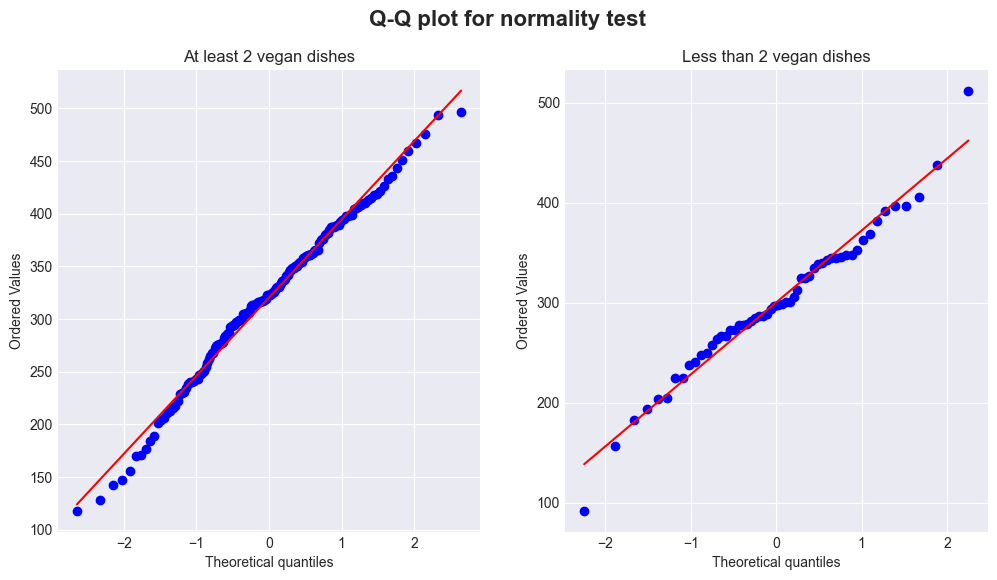

In [11]:
fig = plt.figure(figsize=(12, 6))


ax = fig.add_subplot(121)
stats.probplot(pcs_alot_vegan, dist="norm", plot=ax)
ax.set_title("At least 2 vegan dishes")

ax = fig.add_subplot(122)
stats.probplot(pcs_not_alot_vegan, dist="norm", plot=ax)
ax.set_title("Less than 2 vegan dishes")

fig.suptitle("Q-Q plot for normality test", fontweight='bold', fontsize=16)
fig.show()

## Calculate t statistic

In [12]:
RESTAURANT = ['Chemicum', 'Exactum', 'Physicum']

pvals = []
for restaurant in RESTAURANT:
    dishes_res = dishes[dishes['restaurant'] == restaurant]

    dishes_res['alot_vegan'] = dishes_res['num_cat_vegan'] >= 2

    pcs_alot_vegan = dishes_res[dishes_res['alot_vegan']]['pcs']
    pcs_not_alot_vegan = dishes_res[~dishes_res['alot_vegan']]['pcs']

    if len(pcs_alot_vegan) == 0 or len(pcs_not_alot_vegan) == 0:
        continue

    pval = stats.ttest_ind(pcs_alot_vegan, pcs_not_alot_vegan)[1]

    pvals.append({'restaurant': restaurant, 'p_val':  pval})

df_pvals = pd.DataFrame.from_records(pvals)
df_pvals.head()

,restaurant,p_val
0,Chemicum,0.229144
1,Exactum,0.076310


In [13]:
fig = make_subplots(
    rows=1, cols=1,
    specs=[
        [{'type': 'bar'}]
    ]
)

fig.add_trace(
    go.Bar(x=df_pvals['restaurant'], y=df_pvals['p_val']),
    row=1, col=1
)
fig.add_hline(y=0.05, row=1, col=1, line_width=3, line_dash="dash", line_color="red")

fig.update_layout(
    height=600, 
    width=800,
    legend={'orientation': 'h', 'xanchor': "center", 'y': 1, 'yanchor': "bottom", 'x': 0.5, 'font': {'size': 16}},
    title={'xanchor': 'center', 'text': '<b>Statistical test result of changing in no. pieces <br> when menu has 2 vegan</b>', 'font': {'size': 25}},
)
fig.update_xaxes(tickangle=-40, tickfont={'size': 16})
fig.show()